Useful links

https://stackoverflow.com/questions/39465526/tensorflow-optimize-over-input-with-gradient-descent

merging graphs
https://gist.github.com/marta-sd/ba47a9626ae2dbcc47094c196669fd59
^good one

https://engineering.taboola.com/more-than-one-graph-code-reuse-in-tensorflow/

https://stackoverflow.com/questions/33748552/tensorflow-how-to-replace-a-node-in-a-calculation-graph

https://blog.metaflow.fr/tensorflow-saving-restoring-and-mixing-multiple-models-c4c94d5d7125

hub from checkpoint

https://groups.google.com/a/tensorflow.org/forum/#!msg/hub/QEjKHfdD4X4/MFvx31XNBwAJ

https://github.com/tensorflow/hub/issues/27

https://stackoverflow.com/questions/50747981/create-hub-module-from-existing-checkpoint/50764655#50764655

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100]
rprob = 0.5
shape = (nc, nc, nc)

In [3]:
tf.reset_default_graph()

suff = 'pad2d8regv1'
ftname = ['cic']
nchannels = len(ftname)


cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad

#                                                                                                                                           
niter = 9000
sess = tf.Session()
chkname = suff #+'_it%d'%niter                                                                                                              

# saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))


In [6]:

# with tf.Graph().as_default() as gnew:
#     xop = tf.get_variable('input_image', [1, cube_sizeft, cube_sizeft, cube_sizeft, 1], 
#                           dtype=tf.float32, trainable=True, initializer=tf.constant_initializer(value=1.0))
#     y = tf.placeholder(tf.float32, shape=[1, cube_size, cube_size, cube_size, 1])

    
#     saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))
#     prediction = gnew.get_tensor_by_name('prediction:0')
#     labels = gnew.get_tensor_by_name('labels:0')
#     input = gnew.get_tensor_by_name('input:0')
#     keepprob = gnew.get_tensor_by_name('keepprob:0')
#     loss = gnew.get_collection('losses')[0]
#     gdef = tf.GraphDef()
    
    
# #     lossval = gnew.get_tensor_by_name('sigmoid_cross_entropy_loss/value:0')
#     #     
# #     g = sess.graph
# #     gdef = sess.graph_def

#     loss = tf.import_graph_def(gdef, {'input:0':xop, 'labels:0':y}, ['sigmoid_cross_entropy_loss/value:0'])
#     # NOTE: using identity to get a known name for the output tensor.
#     output = tf.identity(loss, name="output")
#     newloss = tf.losses.mean_squared_error(prediction, y)
# #     newloss2 = tf.losses.mean_squared_error('input:0':xop, y)

# #     xim = xop.assign(input)
# #     tf.assign(input, xop)
    
# gdefnew = gnew.as_graph_def()





In [20]:
# with tf.Session(graph=gnew) as sess2:
# #     saver.restore(sess2,'./../code/models/n%02d/%s/%s'%(numd*1e4, suff, chkname))
    
# #     # check if values were actually restored, not re-initialized
# #     lval = sess2.run([loss, newloss], feed_dict={input:xx, keepprob:1, labels:yy, y:yy})
# #     print(lval)
    

In [14]:
# # saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))
# saver.restore(sess,'./../code/models/n%02d/%s/%s'%(numd*1e4, suff, chkname))
# g = sess.graph
# gdef = sess.graph_def
# prediction = g.get_tensor_by_name('prediction:0')
# labels = g.get_tensor_by_name('labels:0')
# input = g.get_tensor_by_name('input:0')
# keepprob = g.get_tensor_by_name('keepprob:0')
# loss = g.get_collection('losses')[0]
# # loss = g.get_tensor_by_name('loss:0')


In [4]:
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']
    mesh['s'] = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/s/')

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['target'] = hmesh['pnn'].copy()

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels                                                                                                                 
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['target']
    targetmesh[targetmesh > 1] = 1

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
#     recp = sess.run(prediction, feed_dict={input:inp, keepprob:1})
#     mesh['predict'] = dtools.uncubify(recp[:,:,:,:,0], (nc, nc, nc))
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, 100, max_offset,
                                           cube_size, cube_sizeft, seed=seed, rprob=rprob)

    meshes[seed] = [mesh, hmesh]

features = np.stack(features, axis=0)
target = np.stack(target, axis=0)



All the mesh have been generated for seed = 100
Length of targets =  1
Supplemented by rotation :  46


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


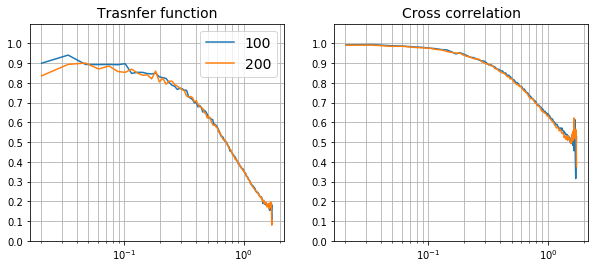

In [5]:
# kk = tools.fftk(shape, bs)
# kmesh = sum(i**2 for i in kk)**0.5


# fig, ax = plt.subplots(1, 2, figsize = (10, 4))
# for seed in seeds:
#     predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'],
#     k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
#     k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
#     k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
#     #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)                                                          
#     #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)                                    

#     ##                                                                                                                                      
#     ax[0].semilogx(k, pkpred/pkhd, label=seed)
#     ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
#     # plt.plot(k, pkpredall/pkhd)                                                                                                           

# ax[0].legend(fontsize=14)
# ax[0].set_title('Trasnfer function', fontsize=14)
# ax[1].set_title('Cross correlation', fontsize=14)
# for axis in ax: axis.set_ylim(0., 1.1)
# for axis in ax: axis.set_yticks(np.arange(0, 1.1, 0.1))
# for axis in ax: axis.grid(which='both')


# Module

In [233]:
xx = features[0:1].copy()
yy = target[0:1].copy()

xx2 = xx[:, 2:34, 2:34, 2:34, :].copy()
xx2.shape

(1, 32, 32, 32, 1)

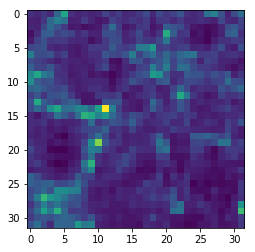

In [234]:
plt.imshow(xx2.reshape(32, 32, 32).sum(axis=0))

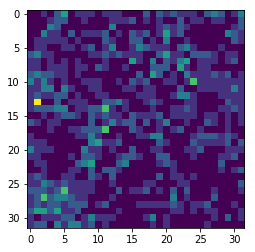

In [235]:
plt.imshow(yy.reshape(32, 32, 32).sum(axis=0))

In [201]:
tf.reset_default_graph()

mm = hub.Module('tfplay2.hub', trainable=False)
# xxopt = tf.Variable(name='xxopt', initial_value=np.ones(xx2.shape).astype(float32))
xxcheck = tf.placeholder(float32, xx2.shape, name='input')
xxopt = tf.get_variable(name='xxopt', shape=xx2.shape, initializer=tf.initializers.ones)
yytrue = tf.placeholder(float32, xx2.shape, name='truth')
lr = tf.placeholder(float32, name='learningrate')

output = mm(dict(inp=xxopt, labs=yytrue))
outputcheck = mm(dict(inp=xxcheck, labs=yytrue))
# loss = tf.losses.mean_pairwise_squared_error(yytrue, output)
loss = tf.losses.sigmoid_cross_entropy(yytrue, output)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[xxopt])
# opt_op = optimizer.minimize(tf.reduce_sum(output))




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [203]:
session = tf.Session()
session.run(tf.initializers.global_variables())

valin = session.run(xxopt.value())

losses = []
outs = []
lr0 = 1000
nlr = 5000
for i in range(30000):
    if i%nlr == 0: 
        lr0 /= 10.
        print(lr0)
    _, l = session.run([opt_op, loss], feed_dict={yytrue:yy, lr:lr0})
#     l, out = session.run([loss, output])
    losses.append(l)


100.0
10.0
1.0
0.1
0.01
0.001


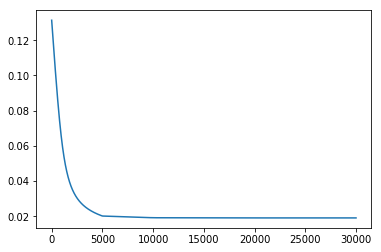

In [204]:
plt.plot(losses)

In [205]:
# val = session.run(xxopt.value())
val = session.run(xxopt)

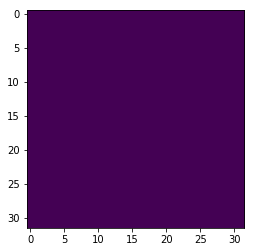

In [206]:
plt.imshow(valin.reshape(32, 32, 32).sum(axis=0))

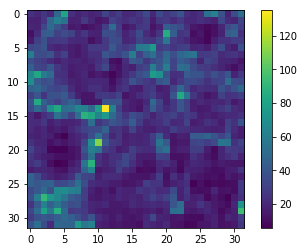

In [222]:
im = plt.imshow(xx2.reshape(32, 32, 32).sum(axis=0))
plt.colorbar(im)

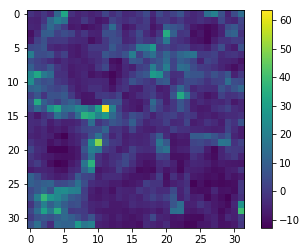

In [223]:
xx22 = (xx2 - xx2.mean())/xx2.std()
im = plt.imshow(xx22.reshape(32, 32, 32).sum(axis=0))
plt.colorbar(im)

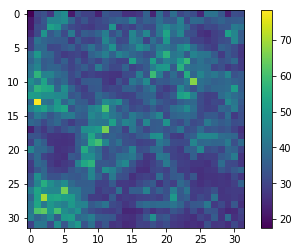

In [224]:
im = plt.imshow(val.reshape(32, 32, 32).sum(axis=0))
plt.colorbar(im)

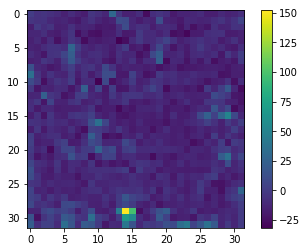

In [225]:
im = plt.imshow((xx2- val)[0, :, :, :, 0].sum(axis=-1))
plt.colorbar(im)

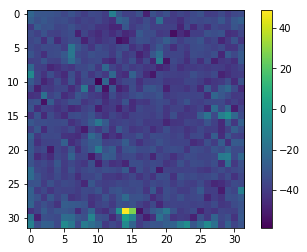

In [226]:
im = plt.imshow((xx22- val)[0, :, :, :, 0].sum(axis=-1))
plt.colorbar(im)

In [227]:
out1 = session.run(tf.nn.sigmoid(outputcheck), feed_dict={yytrue:yy, xxcheck:xx2})
out2 = session.run(tf.nn.sigmoid(outputcheck), feed_dict={yytrue:yy, xxcheck:val})

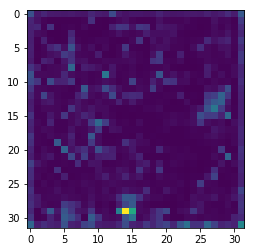

In [228]:
im = plt.imshow(out1[0, :, :, :, 0].sum(axis=-1))

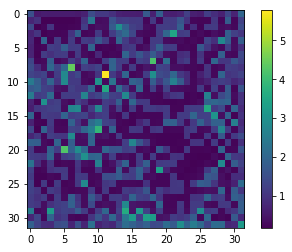

In [231]:
im = plt.imshow(out2[0, :, :, :, 0].sum(axis=-1))
plt.colorbar(im)

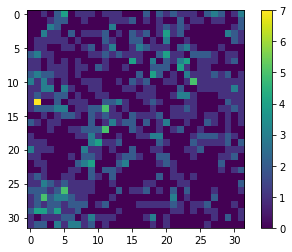

In [232]:
im = plt.imshow(yy.reshape(32, 32, 32).sum(axis=0))
plt.colorbar(im)

In [ ]:
plt.imshow(yy.reshape(32, 32, 32).sum(axis=0))

# Grad

In [16]:
# with tf.Graph().as_default() as gnew:
#     xop = tf.get_variable('input_image', [1, cube_sizeft, cube_sizeft, cube_sizeft, 1], 
#                           dtype=tf.float32, trainable=True, initializer=tf.constant_initializer(value=1.0))
#     y = tf.placeholder(tf.float32, shape=[1, cube_size, cube_size, cube_size, 1])

    
#     saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))
#     saver.restore(sess,'./../code/models/n%02d/%s/%s'%(numd*1e4, suff, chkname))
#     g = sess.graph
#     gdef = sess.graph_def

#     loss = tf.import_graph_def(gdef, {'input:0':xop, 'labels:0':y}, ['sigmoid_cross_entropy_loss/value:0'])
#     # NOTE: using identity to get a known name for the output tensor.
#     output = tf.identity(loss, name="output")

# gdefnew = gnew.as_graph_def()

INFO:tensorflow:Restoring parameters from ./../code/models/n10/pad2d8regv1/pad2d8regv1


In [22]:
# #your starting image
# start_value = (np.ones((4, 4), dtype=np.float32) + np.eye(4))[None, :, :, None]


# # override variable_getter
# def nontrainable_getter(getter, *args, **kwargs):
#     kwargs['trainable'] = False
#     return getter(*args, **kwargs)


# # all variables in this scope are not trainable
# with tf.variable_scope('myscope', custom_getter=nontrainable_getter):
#     x = tf.layers.dense(img_op, 10)
#     y = tf.layers.dense(x, 10)

# the usual stuff

# cost_op = tf.losses.mean_squared_error(prediction, y)
# train_op = tf.train.AdamOptimizer(0.1).minimize(cost_op, var_list = [xass])

# fire up the training process
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(img_assign, {data_pldhr: start_value})

#     print(sess.run(img_op))
#     for i in range(10):
#         _, c = sess.run([train_op, cost_op])
#         print(c)
#     print(sess.run(img_op))